# LSTM 时间序列预测演示

这个 Jupyter Notebook 演示了如何使用 LSTM 神经网络进行时间序列预测。

## 目录
1. [导入库和设置](#1-导入库和设置)
2. [数据生成](#2-数据生成)
3. [数据预处理](#3-数据预处理)
4. [模型定义](#4-模型定义)
5. [模型训练](#5-模型训练)
6. [预测和评估](#6-预测和评估)
7. [结果可视化](#7-结果可视化)

## 1. 导入库和设置

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 设置 matplotlib 中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 检查设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用设备: {device}')

使用设备: cpu


## 2. 数据生成

我们将生成一个包含趋势、季节性和噪声的复杂时间序列。

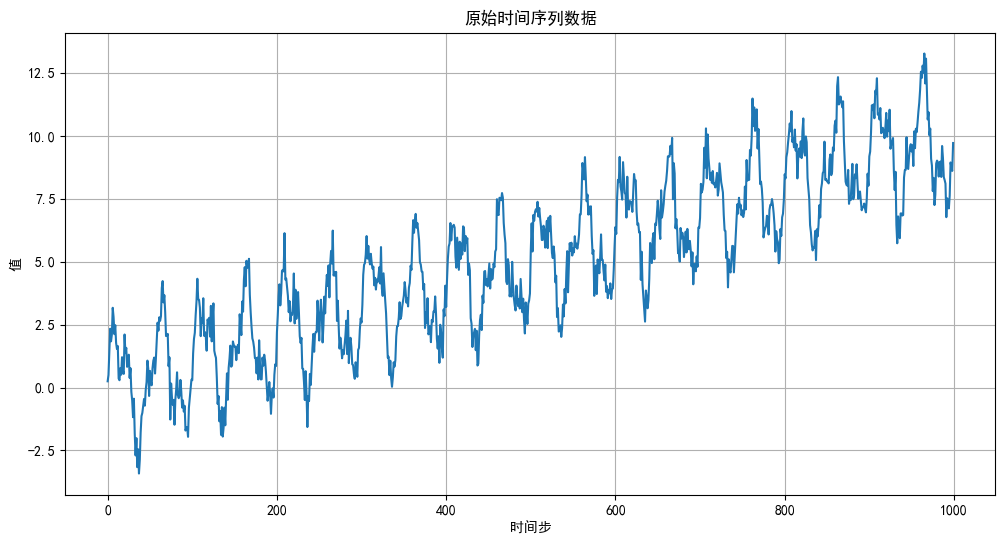

数据长度: 1000


In [2]:
def generate_time_series(length=1000):
    """生成复杂时间序列数据"""
    x = np.arange(length)
    
    # 趋势分量
    trend = 0.01 * x
    
    # 季节性分量
    seasonal = 2 * np.sin(2 * np.pi * x / 50) + np.sin(2 * np.pi * x / 20)
    
    # 噪声分量
    noise = np.random.normal(0, 0.5, length)
    
    return trend + seasonal + noise

# 生成数据
data = generate_time_series(1000)

# 可视化原始数据
plt.figure(figsize=(12, 6))
plt.plot(data)
plt.title('原始时间序列数据')
plt.xlabel('时间步')
plt.ylabel('值')
plt.grid(True)
plt.show()

print(f'数据长度: {len(data)}')

## 3. 数据预处理

将时间序列数据转换为监督学习问题的格式。

In [3]:
def create_sequences(data, seq_length, pred_steps=1):
    """创建序列数据"""
    X, y = [], []
    
    for i in range(len(data) - seq_length - pred_steps + 1):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length:i + seq_length + pred_steps])
    
    return np.array(X), np.array(y)

# 数据归一化
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data.reshape(-1, 1)).flatten()

# 创建序列
sequence_length = 20
X, y = create_sequences(data_normalized, sequence_length)

# 分割训练和测试集
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 转换为 PyTorch 张量
X_train_tensor = torch.FloatTensor(X_train).unsqueeze(-1)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test).unsqueeze(-1)
y_test_tensor = torch.FloatTensor(y_test)

print(f'训练集形状: {X_train_tensor.shape}')
print(f'测试集形状: {X_test_tensor.shape}')

训练集形状: torch.Size([784, 20, 1])
测试集形状: torch.Size([196, 20, 1])


## 4. 模型定义

定义 LSTM 神经网络模型。

In [4]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        
        return out

# 创建模型
model = LSTMModel(input_size=1, hidden_size=50, num_layers=2, output_size=1, dropout=0.2)
model = model.to(device)

# 损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f'模型参数数量: {sum(p.numel() for p in model.parameters())}')

模型参数数量: 31051


## 5. 模型训练

训练 LSTM 模型并监控训练过程。

In [5]:
# 移动数据到设备
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# 训练参数
epochs = 50
batch_size = 32

# 存储损失
train_losses = []
val_losses = []

print('开始训练...')

for epoch in range(epochs):
    model.train()
    
    # 训练
    total_train_loss = 0
    for i in range(0, len(X_train_tensor), batch_size):
        batch_x = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # 验证
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
    
    avg_train_loss = total_train_loss / (len(X_train_tensor) // batch_size)
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss.item():.6f}')

print('训练完成!')

开始训练...
Epoch [10/50], Train Loss: 0.014147, Val Loss: 0.008974
Epoch [20/50], Train Loss: 0.008051, Val Loss: 0.003746
Epoch [30/50], Train Loss: 0.005813, Val Loss: 0.002090
Epoch [40/50], Train Loss: 0.005374, Val Loss: 0.001779
Epoch [50/50], Train Loss: 0.004367, Val Loss: 0.001688
训练完成!


## 6. 预测和评估

使用训练好的模型进行预测并评估性能。

In [6]:
# 预测
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    predictions = predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()

# 反归一化
predictions_denorm = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
y_test_denorm = scaler.inverse_transform(y_test_np.reshape(-1, 1)).flatten()

# 计算评估指标
mse = np.mean((predictions_denorm - y_test_denorm) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(predictions_denorm - y_test_denorm))

print('模型性能评估:')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

模型性能评估:
MSE: 0.4702
RMSE: 0.6857
MAE: 0.5614


## 7. 结果可视化

可视化训练过程和预测结果。

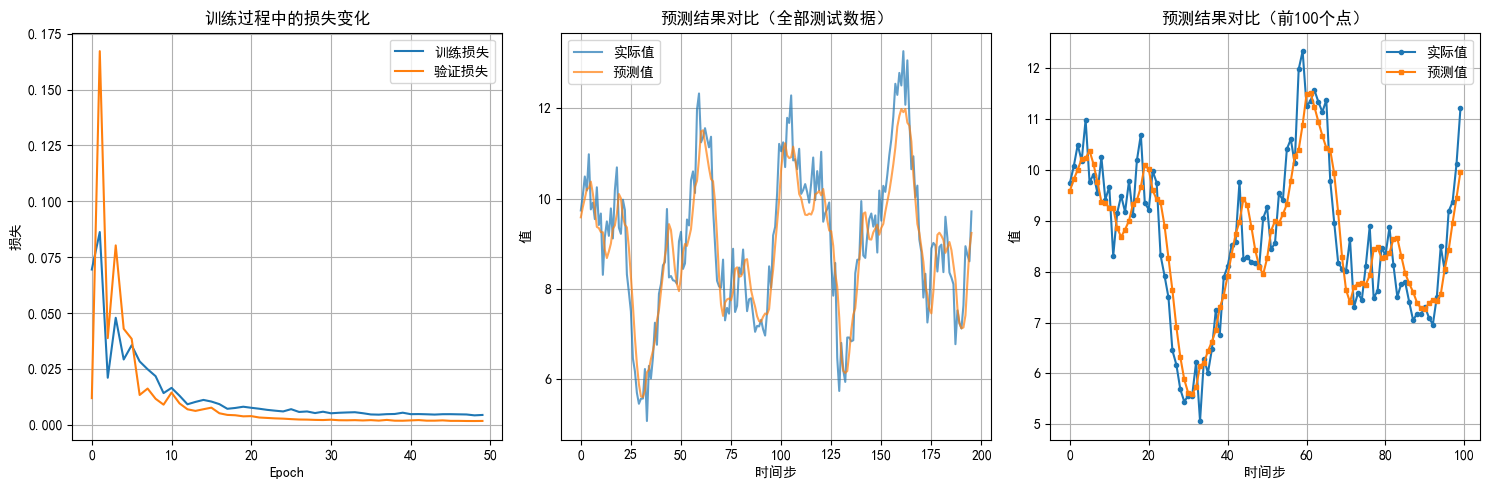

In [7]:
# 绘制训练损失
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='训练损失')
plt.plot(val_losses, label='验证损失')
plt.title('训练过程中的损失变化')
plt.xlabel('Epoch')
plt.ylabel('损失')
plt.legend()
plt.grid(True)

# 绘制预测结果（全部）
plt.subplot(1, 3, 2)
plt.plot(y_test_denorm, label='实际值', alpha=0.7)
plt.plot(predictions_denorm, label='预测值', alpha=0.7)
plt.title('预测结果对比（全部测试数据）')
plt.xlabel('时间步')
plt.ylabel('值')
plt.legend()
plt.grid(True)

# 绘制预测结果（前100个点）
plt.subplot(1, 3, 3)
display_length = min(100, len(y_test_denorm))
plt.plot(y_test_denorm[:display_length], label='实际值', marker='o', markersize=3)
plt.plot(predictions_denorm[:display_length], label='预测值', marker='s', markersize=3)
plt.title(f'预测结果对比（前{display_length}个点）')
plt.xlabel('时间步')
plt.ylabel('值')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 单步预测演示

演示如何使用模型进行单步预测。

单步预测演示:
输入序列的最后5个值: [7.4451942 8.469142  8.311661  9.153225  9.344129 ]
实际下一个值: 9.7373
预测下一个值: 9.5851
预测误差: 0.1522


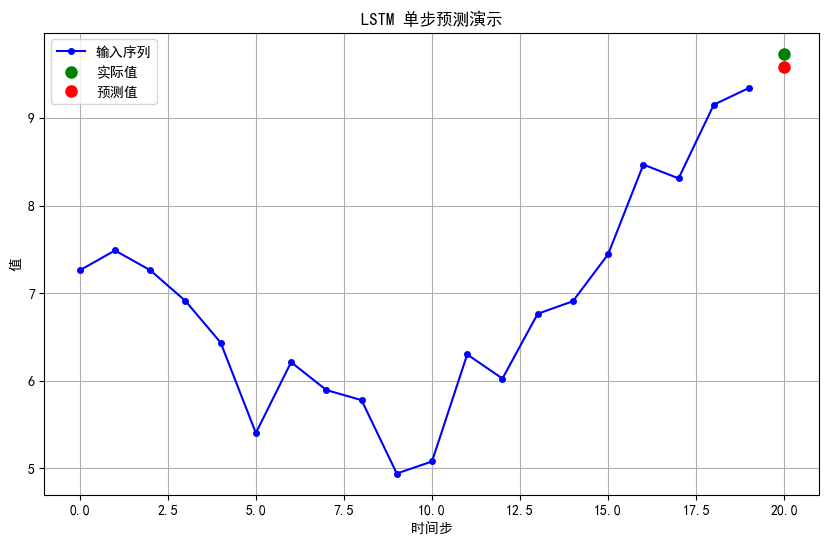

In [8]:
# 选择一个测试序列进行演示
demo_idx = 0
input_sequence = X_test_tensor[demo_idx:demo_idx+1]
actual_value = y_test_tensor[demo_idx:demo_idx+1]

# 预测
model.eval()
with torch.no_grad():
    predicted_value = model(input_sequence)

# 反归一化
input_denorm = scaler.inverse_transform(input_sequence.cpu().numpy().reshape(-1, 1)).flatten()
actual_denorm = scaler.inverse_transform(actual_value.cpu().numpy().reshape(-1, 1)).flatten()
predicted_denorm = scaler.inverse_transform(predicted_value.cpu().numpy().reshape(-1, 1)).flatten()

print('单步预测演示:')
print(f'输入序列的最后5个值: {input_denorm[-5:]}')
print(f'实际下一个值: {actual_denorm[0]:.4f}')
print(f'预测下一个值: {predicted_denorm[0]:.4f}')
print(f'预测误差: {abs(actual_denorm[0] - predicted_denorm[0]):.4f}')

# 可视化单步预测
plt.figure(figsize=(10, 6))
x_range = range(len(input_denorm) + 1)
values = list(input_denorm) + [actual_denorm[0]]

plt.plot(x_range[:-1], values[:-1], 'bo-', label='输入序列', markersize=4)
plt.plot(x_range[-1], actual_denorm[0], 'go', label='实际值', markersize=8)
plt.plot(x_range[-1], predicted_denorm[0], 'ro', label='预测值', markersize=8)

plt.title('LSTM 单步预测演示')
plt.xlabel('时间步')
plt.ylabel('值')
plt.legend()
plt.grid(True)
plt.show()

## 总结

这个演示展示了：

1. **数据生成**: 创建包含趋势、季节性和噪声的复杂时间序列
2. **数据预处理**: 归一化和序列化处理
3. **模型构建**: 多层 LSTM 神经网络
4. **模型训练**: 使用 Adam 优化器和 MSE 损失函数
5. **性能评估**: MSE、RMSE、MAE 指标
6. **结果可视化**: 训练过程和预测结果

### 改进建议

- 尝试不同的网络架构（更多层数、不同隐藏单元数）
- 使用不同的优化器和学习率
- 添加正则化技术（L1/L2、更高的 dropout）
- 尝试双向 LSTM 或 GRU
- 实现多步预测
- 添加注意力机制